# Brief


Task 1. 
<br></br>
On both datasets, conduct model selection. Investigate generalisation and propose two models (i) most accurate and (ii) fairest models. Use five fold cross-validation. Compute metrics on test set.
Metrics: Accuracy and Equality of Opportunity
<br></br>

Task 2.
<br></br>
Perform reweighing (algorithmic fairness method) and evaluate impact of fairness intervention on metrics. Again, select models across hyperparrameter values for each of the two metrics. Propose models optimised for each metric.
<br></br>

# Task 1


## Evaluation of Adult and German Datasets with respect to Accuracy and Fairness

Use a logistic regression model to model AIF360 Adult and German Data

## Notes

Weight dacay, C, learning rate and other hyperparameters

## Evaluate generalization
C is a term that balances fit and generalisation ability
evaluation on the left out fold, compared to 
validation: validating model fit.

Steps:
try different Cs, take average of perfomance over all folds for each given set of folds.
Best model in terms of acuracy of fairness gives 'best'model.

Then use entire training set with the selected C. Evaluate and report results in a table.



## Adult Dataset


## 1.1 Load Packages and Adult Data


In [2]:
!pip install 'aif360[LFR]'

     |████████████████████████████████| 175 kB 4.4 MB/s 
     |████████████████████████████████| 564 kB 48.7 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=1809a09ef2de8d166cebc8e9a9ab85d081736ac98096b3ed1e85f25c4cbf3186
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [ ]:
# Move to correct directory for adult dataset

In [3]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-05-14 12:09:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  3.64MB/s    in 1.0s    

2022-05-14 12:09:14 (3.64 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-05-14 12:09:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2022-

In [ ]:
# cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

In [49]:
# cell needs to be run twice for some reason

# Load all necessary packages
%matplotlib inline
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset
from aif360.metrics import ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing import LFR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from matplotlib.pyplot import figure
import seaborn as sb

# from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import StratifedKFold
# from common_utils import compute_metrics

import pdb

##1.2  Adult Dataset Preprocessing - Loading, Train-Test Split and Normalisation

Load dataset and set protected characteristics options for Adult dataset.
<br></br>
Protected features for Adult Dataset - Sex.

In [57]:
# import dataset
initial_dataset = load_preproc_data_adult(['sex'])

### 1.2.1 Adult Dataset - Train/Test Split, Normalisation

In [58]:
#Split between training and test set.
train_adult, test_adult = initial_dataset.split([0.7], shuffle=True)

#Normalize the features dataset [x], both train and test.
normalize_data = StandardScaler()
adult_x_train = normalize_data.fit_transform(train_adult.features)
adult_y_train = train_adult.labels.ravel()

adult_x_test = normalize_data.transform(test_adult.features) 
adult_y_test = test_adult.labels.ravel()

# Define protected attribute: For Adult Dataset [load_preproc_data_adult]
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

### 1.2.2 Data information

In [ ]:
print("Full dataset dimensions", initial_dataset.features.shape)
print("Full dataset feature names", initial_dataset.feature_names)

Full dataset dimensions (48842, 18)
Full dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


The dimensions of the data, as well as the features of the data is explored in order to guide the selection of the model type.

## 1.3 Adult Dataset  - Model Selection

### 1.3.1 Model Selection classes and functions

In [9]:
class LogisticClassifier():
  def __init__(self, dataset, unprivileged_groups, privileged_groups, solver="liblinear", C=0.1, penalty="l2", l1_ratio=None):
    # keep track of current split during cross validation
    self.current_k = 0

    # cross validation
    self.cv = KFold(n_splits=5, random_state=None, shuffle=False)

    # spliting the dataset
    self.splits = dataset.split(5)

    # privileged_groups and unprivileged_groups
    self.unprivileged_groups = unprivileged_groups
    self.privileged_groups = privileged_groups

    # normalize data
    self.scale_orig = StandardScaler()

    # logisitic regression model
    self.model = LogisticRegression(solver=solver, C=C, penalty=penalty, l1_ratio= l1_ratio if l1_ratio else None)

  def scale(self, data):
    """
    Normalize data
    """
    x = self.scale_orig.fit_transform(data.features)
    y = data.labels.ravel()

    return x, y

  def train(self, X, y, fit_params):
    self.model.fit(X, y, fit_params)

  def predict(self, X):
    return self.model.predict(X)

  def __fairness__(self, clf, X, y):
    current_split = self.splits[self.current_k]

    # scale
    X, _unused_y = self.scale(current_split)

    # predict
    predictions = self.predict(X) 

    test_pred = current_split.copy()
    test_pred.labels = predictions

    metric = ClassificationMetric(current_split, test_pred, unprivileged_groups=self.unprivileged_groups, privileged_groups=self.privileged_groups)

    self.current_k += 1
    
    return metric.equal_opportunity_difference()

  def accuracy(self, x_train, y_train):
    scores = cross_val_score(self.model, x_train, y_train, cv=self.cv, scoring="accuracy")

    return np.mean(scores)

  def accuracy_raw(self, x_train, y_train):
    scores = cross_val_score(self.model, x_train, y_train, cv=self.cv, scoring="accuracy")

    return scores

  def fairness_raw(self, x_train, y_train):
    fscores = cross_val_score(self.model, x_train, y_train, cv=self.cv, scoring=self.__fairness__)

    return fscores

  def accuracy_fairness_score(self, x_train, y_train):
    """
    Get accuracy+fairness score
    """
    scores = cross_val_score(self.model, x_train, y_train, cv=self.cv, scoring=self.__differentialscoring__)

    # reset current split
    self.current_k = 0

    return np.mean(scores), scores

  def fairness_model_selection(self, x_train, y_train):
    current_k = 0

    # cross validation
    scores = cross_val_score(self.model, x_train, y_train, cv=self.cv, scoring=self.__fairness__)

    # update current split index
    self.current_k = 0

    # get fairness
    fairness = np.mean(scores)

    return fairness

  def __differentialscoring__(self, clf=None, X=None, y=None):
    """
    This accounts for both accuracy and fairness
    """
    # current split
    split = self.splits[self.current_k]
    predictions = self.predict(X)
    test_pred = split.copy()
    test_pred.labels = predictions
    metric = ClassificationMetric(split, test_pred, unprivileged_groups=self.unprivileged_groups, privileged_groups=self.privileged_groups)
    fmetric = metric.equal_opportunity_difference()
    accuracy = self.accuracy(X,y)
    # cycle through k
    self.current_k += 1

    return accuracy - fmetric

In [10]:
# convert rawscore to labelled dataframe of scores
def scores_to_df(rawscores):
  df = pd.DataFrame(np.row_stack(rawscores))
  df_new = df.rename(columns={0: 'Fold_1', 1: 'Fold_2', 2: 'Fold_3',  3: 'Fold_4',  4: 'Fold_5'},
                              index={0: '0.00001', 1: '0.0001', 2: '0.001', 3: '0.01', 4: '0.1', 5: '1'})
  # df_new['index'] = df_new.index
  df_new_transposed = df_new.T
  return df_new_transposed

### 1.3.2 Model Selection - Accuracy, Fairness

Equality of opportunity is the fairness metric of choice. We compute the diffference in TPR between both groups, defined by the protected attribute.
<br> </br> 
The c values tested were: 1.0, 0.1, 0.01, 0.001 0.0001 and 0.00001.

In [59]:
# Instantiate Classifier
adult_clf = LogisticClassifier(train_adult, unprivileged_groups, privileged_groups)
# train classifier
adult_clf.train(adult_x_train, adult_y_train,None)

In [60]:
# For original adult dataset
# Compute fairness and accuracy over folds and over Cs
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
fairness = []
accuracy = []
accuracy_raw = []
fairness_raw = []

for value in C:
  clf = LogisticClassifier(train_adult, unprivileged_groups, privileged_groups, C=value, solver="liblinear", penalty="l2")
  clf.train(adult_x_train, adult_y_train,None)
  fairness.append(clf.fairness_model_selection(adult_x_train, adult_y_train))
  accuracy.append(clf.accuracy(adult_x_train, adult_y_train))
  accuracy_raw.append(clf.accuracy_raw(adult_x_train, adult_y_train))
  fairness_raw.append(clf.fairness_raw(adult_x_train, adult_y_train))
    

In [61]:
display(Markdown("#### Original Adult training dataset Metrics"))

# Best Accuracy score, Fairness score and corresponding Cs
adult_accuracy_comparison = dict(zip(C, accuracy))
best_C_acc = max(adult_accuracy_comparison, key=lambda key: adult_accuracy_comparison[key])
adult_fairness_comparison = dict(zip(C, fairness))
best_C_fair = max(adult_fairness_comparison, key=lambda key: adult_fairness_comparison[key])
print("Best C value for accuracy: ", best_C_acc, "with score:", adult_accuracy_comparison[best_C_acc])
print("Best C value for fairness: ", best_C_fair, "with score:", adult_fairness_comparison[best_C_fair])

#### Original Adult training dataset Metrics

Best C value for accuracy:  0.01 with score: 0.8028604487317452
Best C value for fairness:  0.0001 with score: -0.24254491326550193


### 1.3.3 Observations and plots

Given the resuts above, a Logistic Regression model with a hyper-parameter value of **C = 0.1** has been selected as the best performing model, in terms of accuracy, from the model selction process.
<br></br>
The best model in terms of fairness however is a Logistic regression model for which **C = 0.00001**.

<br></br>
The observed results change intermittently between runs.

In [65]:
accuracy_raw_df_new = scores_to_df(accuracy_raw)

In [66]:
print(accuracy_raw_df_new)

         0.00001    0.0001     0.001      0.01       0.1         1
Fold_1  0.800380  0.800965  0.804767  0.805499  0.805499  0.805499
Fold_2  0.793214  0.792629  0.801404  0.801696  0.801696  0.801696
Fold_3  0.797163  0.797163  0.806230  0.805937  0.805937  0.805937
Fold_4  0.793507  0.795116  0.802428  0.802428  0.802428  0.802428
Fold_5  0.794354  0.794939  0.798888  0.798742  0.798742  0.798742


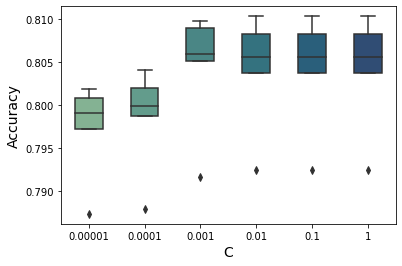

In [ ]:
# Plot boxplot for Accuracy
bplot = sb.boxplot( 
                 data=accuracy_raw_df_new, 
                 width=0.5,
                 palette="crest")
# bplot.axes.set_title("Model Comparison, accuracy, Original Adult Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("Accuracy", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=accuracy_raw_df_new, 
#               color='black',
#               alpha=0.75)

In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_accuracy_OriginalAdult.jpg"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

Fairness

In [ ]:
fairness_raw_df_new = scores_to_df(fairness_raw)

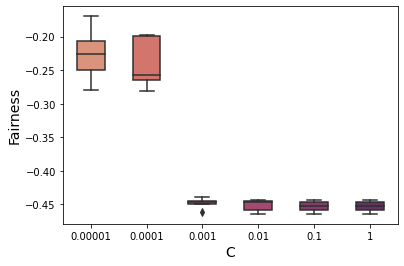

In [ ]:
# Plot boxplot for fairness
bplot = sb.boxplot( 
                 data=fairness_raw_df_new, 
                 width=0.5,
                 palette="flare")
# bplot.axes.set_title("Model Comparison, fairness, Original Adult Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("Fairness", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=fairness_raw_df_new, 
#               color='black',
#               alpha=0.75)

In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_fairness_OriginalAdult.png"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

## 1.4 Adult Dataset - Model Testing

### 1.4.1 Model Testing -  Accuracy, Fairness

In [63]:
display(Markdown("#### Original Adult dataset"))
print("Final Accuracy Score of Model 1A for Adult Dataset = %f" % adult_clf.accuracy(adult_x_test, adult_y_test))

#### Original Adult dataset

Final Accuracy Score of Model 1A for Adult Dataset = 0.806592


In [64]:
display(Markdown("#### Original Adult dataset"))
print("Final Fairness Score of Model 2A for Adult Dataset = %f" % adult_clf.fairness_model_selection(adult_x_test, adult_y_test))

#### Original Adult dataset

Final Fairness Score of Model 2A for Adult Dataset = -0.460644


## 1.5 German Dataset Preprocessing - Loading, Train-Test Split and Normalisation

Load dataset and set protected characteristics options for German dataset.
<br></br>
Protected features for German Dataset - Age

In [41]:
# Move to correct directory for german dataset

In [42]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [43]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

--2022-05-14 12:57:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.1’

german.data.1       100%[===================>]  77.92K   297KB/s    in 0.3s    

2022-05-14 12:57:19 (297 KB/s) - ‘german.data.1’ saved [79793/79793]

--2022-05-14 12:57:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc.1’

german.doc.1        100%[===================>]   4.57K  --.-KB/s    i

In [44]:
initial_dataset_2 = load_preproc_data_german(['age'])

In [45]:
# Alt3
# German dataset loaded in as 'initial_dataset_2'. Split between training and test set.
# Cell must be re-rerun when switching between datasets for analyses. Priv, unpriv group assignments vital

train_german, test_german = initial_dataset_2.split([0.7], shuffle=True)

#Normalize the features dataset [x], both train and test.
normalize_data = StandardScaler()
german_x_train = normalize_data.fit_transform(train_german.features)
german_y_train = train_german.labels.ravel()

german_x_test = normalize_data.transform(test_german.features) 
german_y_test = test_german.labels.ravel()

# Define protected attribute: For German Dataset [load_preproc_data_german]
privileged_groups = [{'age': 1}] 
unprivileged_groups = [{'age': 0}]

In [46]:
print("training data size", initial_dataset_2.features.shape)
print("dataset feature names", initial_dataset_2.feature_names)

training data size (1000, 11)
dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


## 1.6 German Dataset  - Model Selection

### 1.6.1 Model Selection - Accuracy, Fairness

Given the resuts above, a Logistic Regression model with a hyper-parameter value of **C = 1** has been selected as the best performing model, in terms of accuracy, from the model selction process.

In [ ]:
# Instantiate Classifier
german_clf = LogisticClassifier(train_german, unprivileged_groups, privileged_groups)
# train classifier
german_clf.train(german_x_train, german_y_train, None)

In [ ]:
# For original adult dataset
# Compute fairness and accuracy over folds and over Cs
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
fairness = []
accuracy = []
accuracy_raw = []
fairness_raw = []

for value in C:
  clf = LogisticClassifier(train_german, unprivileged_groups, privileged_groups, C=value, solver="liblinear", penalty="l2")
  clf.train(german_x_train, german_y_train, None)
  fairness.append(clf.fairness_model_selection(german_x_train, german_y_train))
  accuracy.append(clf.accuracy(german_x_train, german_y_train))
  accuracy_raw.append(clf.accuracy_raw(german_x_train, german_y_train))
  fairness_raw.append(clf.fairness_raw(german_x_train, german_y_train))
    

In [ ]:
display(Markdown("#### Original German training dataset Metrics"))

# Best Accuracy score, Fairness score and corresponding Cs
german_accuracy_comparison = dict(zip(C, accuracy))
best_C_acc = max(german_accuracy_comparison, key=lambda key: german_accuracy_comparison[key])
german_fairness_comparison = dict(zip(C, fairness))
best_C_fair = max(german_fairness_comparison, key=lambda key: german_fairness_comparison[key])
print("Best C value for accuracy: ", best_C_acc, "with score:", german_accuracy_comparison[best_C_acc])
print("Best C value for fairness: ", best_C_fair, "with score:", german_fairness_comparison[best_C_fair])

#### Original German training dataset Metrics

Best C value for accuracy:  0.1 with score: 0.69
Best C value for fairness:  1e-05 with score: -0.30230768349691095


### 1.6.2 Observations and plots

Given the resuts above, a Logistic Regression model with a hyper-parameter value of **C = 0.01** has been selected as the best performing model, in terms of accuracy, from the model selction process.
<br></br>
The best model in terms of fairness however is a Logistic regression model for which **C = 0.001**.

In [ ]:
accuracy_raw_df_new = scores_to_df(accuracy_raw)

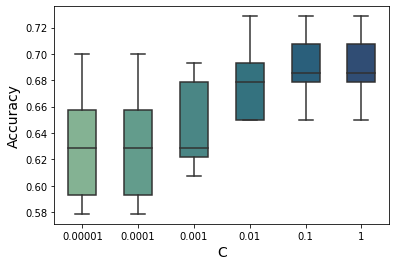

In [ ]:
# Plot boxplot for Accuracy
bplot = sb.boxplot( 
                 data=accuracy_raw_df_new, 
                 width=0.5,
                 palette="crest")
# bplot.axes.set_title("Model Comparison, accuracy, Original Adult Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("Accuracy", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=accuracy_raw_df_new, 
#               color='black',
#               alpha=0.75)

In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_accuracy_OriginalGerman.jpg"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

## 1.7 German Dataset - Model Testing

In [ ]:
display(Markdown("#### Original German dataset"))
print("Final Accuracy Score of Model 1G for German Dataset = %f" % german_clf.accuracy(german_x_test, german_y_test))

#### Original German dataset

Final Accuracy Score of Model 1G for German Dataset = 0.720000


In [ ]:
display(Markdown("#### Original German dataset"))
print("Final Fairness Score of Model 2G for German Dataset = %f" % german_clf.fairness_model_selection(german_x_test, german_y_test))

#### Original German dataset

Final Fairness Score of Model 2G for German Dataset = -0.520145


# Task 2: Modification and Evaluation of modified Datasets as in Task 1

The two datasets examined in section 1 are now de-biased using the reweighing pre-processing algorithm.

## 2.1 Reweighing of Datasets 

This notebook demonstrates the use of a reweighing pre-processing algorithm for bias mitigation

Using the reweighing pre-processing algorithm, the datasets are transformed.

In [ ]:
# Mitigate the bias via reweighing.
# Use the fit method like a classifier, use the generated instance weights in the training phase in subsequent step.
# switch back working directory for adult dataset 
# do german first because it is active dataset

# Dataset 2- German
# also redefine privileged and unprivileged groupings -
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
#obtain weights for the training set
reweighed_train_german = RW.fit_transform(train_german)
print("German RW Dataset - subgroup weights: ", np.unique(reweighed_train_german.instance_weights))



German RW Dataset - subgroup weights:  [0.69114754 0.95382353 1.12076923 1.2512    ]


In [ ]:
# Dataset 1 - Adult
# Define protected attribute: For Adult Dataset [load_preproc_data_adult]
# also redefine privileged and unprivileged groupings -
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
#obtain weights for the training set
reweighed_train_adult = RW.fit_transform(train_adult)

print("Adult RW Dataset - subgroup weights: ", np.unique(reweighed_train_adult.instance_weights))


Adult RW Dataset - subgroup weights:  [0.78891423 0.85484319 1.09181847 2.17512888]


## 2.2 Adult Dataset (Reweighed) - Model Selection

### 2.3.2 Model Selection - Accuracy, Fairness

Equality of opportunity is the fairness metric of choice. We compute the diffference in TPR between both groups, defined by the protected attribute.
<br> </br> 
The c values tested were: 1.0, 0.1, 0.01, 0.001 and 0.0001.

In [ ]:
# Instantiate a Classifier
adult_clf_rw = LogisticClassifier(reweighed_train_adult, unprivileged_groups, privileged_groups)
# train classifier
adult_clf_rw.train(adult_x_train, adult_y_train, reweighed_train_adult.instance_weights)

In [ ]:
# For reweighed adult dataset
# Compute fairness and accuracy over folds and over Cs
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
fairness = []
accuracy = []
accuracy_raw = []
fairness_raw = []
for value in C:
  clf = LogisticClassifier(reweighed_train_adult, unprivileged_groups, privileged_groups, C=value, solver="liblinear", penalty="l2")
  clf.train(adult_x_train, adult_y_train, fit_params=reweighed_train_adult.instance_weights)
  fairness.append(clf.fairness_model_selection(adult_x_train, adult_y_train))
  accuracy.append(clf.accuracy(adult_x_train, adult_y_train))
  accuracy_raw.append(clf.accuracy_raw(adult_x_train, adult_y_train))
  fairness_raw.append(clf.fairness_raw(adult_x_train, adult_y_train))

In [ ]:
display(Markdown("#### Reweighed Adult training dataset Metrics"))

# Best Accuracy score, Fairness score and corresponding Cs
adult_accuracy_comparison = dict(zip(C, accuracy))
best_C_acc = max(adult_accuracy_comparison, key=lambda key: adult_accuracy_comparison[key])
adult_fairness_comparison = dict(zip(C, fairness))
best_C_fair = max(adult_fairness_comparison, key=lambda key: adult_fairness_comparison[key])
print("Best C value for accuracy: ", best_C_acc, "with score:", adult_accuracy_comparison[best_C_acc])
print("Best C value for fairness: ", best_C_fair, "with score:", adult_fairness_comparison[best_C_fair])

#### Reweighed Adult training dataset Metrics

Best C value for accuracy:  0.1 with score: 0.8032701262503206
Best C value for fairness:  0.01 with score: -0.012607869286405981


### 2.2.2 Observations and plots

Given the results above, using the reweighed Adult dataset, a Logistic Regression model with a hyper-parameter value of **C = 0.1** has been selected as the best performing model, in terms of accuracy, from the model selection process. It achieves a score of 0.803.
<br></br>
The best model in terms of fairness however is a Logistic regression model for which **C = 0.01**. THis achieves a fairness score very close to zero at -0.01.


In [ ]:
accuracy_raw_df_new = scores_to_df(accuracy_raw)

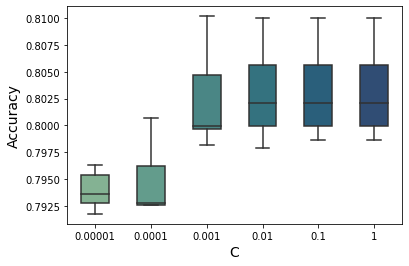

In [ ]:
# Plot boxplot for Accuracy
bplot = sb.boxplot( 
                 data=accuracy_raw_df_new, 
                 width=0.5,
                 palette="crest")
# bplot.axes.set_title("Model Comparison, accuracy, Original Adult Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("Accuracy", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=accuracy_raw_df_new, 
#               color='black',
#               alpha=0.75)

In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_accuracy_OriginalAdult.jpg"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
fairness_raw_df_new = scores_to_df(fairness_raw)

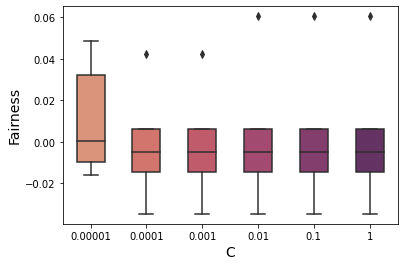

In [ ]:
# Plot boxplot for Accuracy
bplot = sb.boxplot( 
                 data=fairness_raw_df_new, 
                 width=0.5,
                 palette="flare")
# bplot.axes.set_title("Model Comparison, accuracy, Original Adult Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("Fairness", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=accuracy_raw_df_new, 
#               color='black',
#               alpha=0.75)

In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_fairness_ReweighedAdult.jpg"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

## 2.3 Adult Dataset (Reweighed) - Model Testing

In [ ]:
display(Markdown("#### Reweighed Adult dataset"))
print("Final Accuracy Score of Model 3A for Adult Dataset = %f" % adult_clf_rw.accuracy(adult_x_test, adult_y_test))

#### Reweighed Adult dataset

Final Accuracy Score of Model 3A for Adult Dataset = 0.806729


In [ ]:
display(Markdown("#### Reweighed Adult dataset"))
print("Final Fairness Score of Model 4A for Adult Dataset = %f" % adult_clf_rw.fairness_model_selection(adult_x_test, adult_y_test))

#### Reweighed Adult dataset

Final Fairness Score of Model 4A for Adult Dataset = -0.021457


## 2.4 German Dataset (Reweighed)  - Model Selection

### 2.4.1 Model Selection - Accuracy, Fairness

Given the resuts above, a Logistic Regression model with a hyper-parameter value of **C = 1** has been selected as the best performing model, in terms of accuracy, from the model selction process.

In [ ]:
# Instantiate Classifier
german_clf_rw = LogisticClassifier(reweighed_train_german, unprivileged_groups, privileged_groups)
# train classifier
german_clf_rw.train(german_x_train, german_y_train, reweighed_train_german.instance_weights)


In [ ]:
# For reweighed german dataset
# Compute fairness and accuracy over folds and over Cs
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
fairness = []
accuracy = []
accuracy_raw = []
fairness_raw = []

for value in C:
  clf = LogisticClassifier(reweighed_train_german, unprivileged_groups, privileged_groups, C=value, solver="liblinear", penalty="l2")
  clf.train(german_x_train, german_y_train, fit_params=reweighed_train_german.instance_weights)
  fairness.append(clf.fairness_model_selection(german_x_train, german_y_train))
  accuracy.append(clf.accuracy(german_x_train, german_y_train))
  accuracy_raw.append(clf.accuracy_raw(german_x_train, german_y_train))
  fairness_raw.append(clf.fairness_raw(german_x_train, german_y_train))
    

In [ ]:
display(Markdown("#### Reweighed German training dataset Metrics"))

# Best Accuracy score, Fairness score and corresponding Cs
german_accuracy_comparison = dict(zip(C, accuracy))
best_C_acc = max(german_accuracy_comparison, key=lambda key: german_accuracy_comparison[key])
german_fairness_comparison = dict(zip(C, fairness))
best_C_fair = max(german_fairness_comparison, key=lambda key: german_fairness_comparison[key])
print("Best C value for accuracy: ", best_C_acc, "with score:", german_accuracy_comparison[best_C_acc])
print("Best C value for fairness: ", best_C_fair, "with score:", german_fairness_comparison[best_C_fair])

#### Reweighed German training dataset Metrics

Best C value for accuracy:  0.01 with score: 0.69
Best C value for fairness:  0.01 with score: 0.04842538163590802


### 2.4.2 Observations and plots

Given the resuts above, a Logistic Regression model with a hyper-parameter value of **C = 0.01** has been selected as the best performing model, in terms of both accuracy and fairness, from the model selction process.
<br></br>
The scores at **C = 0.001** are 0.69 for accuracy and 0.04 for fairness.

In [ ]:
accuracy_raw_df_new = scores_to_df(accuracy_raw)

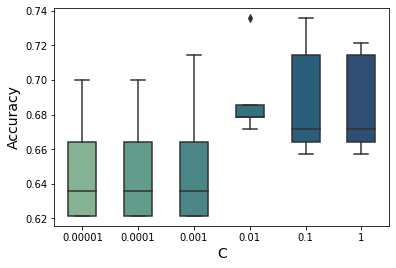

In [ ]:
# Plot boxplot for Accuracy
bplot = sb.boxplot( 
                 data=accuracy_raw_df_new, 
                 width=0.5,
                 palette="crest")
# bplot.axes.set_title("Model Comparison, accuracy, Reweighed German Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("Accuracy", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=accuracy_raw_df_new, 
#               color='black',
#               alpha=0.75)

In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_accuracy_OriginalGerman.jpg"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

Fairness


In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_accuracy_OriginalAdult.jpg"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
fairness_raw_df_new = scores_to_df(fairness_raw)

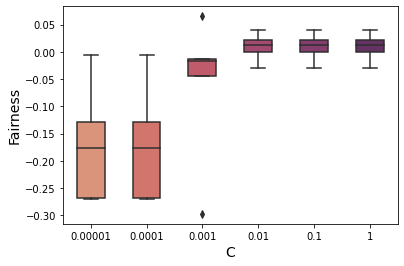

In [ ]:
# Plot boxplot for Fairness
bplot = sb.boxplot( 
                 data=fairness_raw_df_new, 
                 width=0.5,
                 palette="flare")
# bplot.axes.set_title("Model Comparison, Fairness, Reweighed German Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("Fairness", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=Fairness_raw_df_new, 
#               color='black',
#               alpha=0.75)

In [ ]:
#  output file name
plot_file_name="boxplot_ModelComparison_fairness_ReweighedGerman.png"
 
# save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

## 2.5 German Dataset (Reweighed) - Model Testing

In [ ]:
display(Markdown("#### Original German dataset"))
print("Final Accuracy Score of Model 3G for German Dataset = %f" % german_clf.accuracy(german_x_test, german_y_test))

#### Original German dataset

Final Accuracy Score of Model 3G for German Dataset = 0.736667


In [ ]:
display(Markdown("#### Original German dataset"))
print("Final Fairness Score of Model 4G for German Dataset = %f" % german_clf_rw.fairness_model_selection(german_x_test, german_y_test))

#### Original German dataset

Final Fairness Score of Model 4G for German Dataset = 0.019726


## 3.1 Evaluating a blended Fairness-Accuracy Metric

Custom Metric which balances fairness and accuracy

## 3.1.1 Adult Dataset

In [12]:
# Instantiate Classifier
adult_clf_diff = LogisticClassifier(train_adult, unprivileged_groups, privileged_groups)
# train classifier
adult_clf_diff.train(adult_x_train, adult_y_train,None)

Train Adult

In [16]:
# For original adult dataset
# Compute fairdiff and accuracy over folds and over Cs
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
fairdiff = []
fairdiff_scores = []

for value in C:
  clf = LogisticClassifier(train_adult, unprivileged_groups, privileged_groups, C=value, solver="liblinear", penalty="l2")
  clf.train(adult_x_train, adult_y_train,None)
  mean, scores = clf.accuracy_fairness_score(adult_x_train, adult_y_train)                                                               
  fairdiff.append(mean)
  fairdiff_scores.append(scores)

In [17]:
fairdiff_new = scores_to_df(fairdiff_scores)

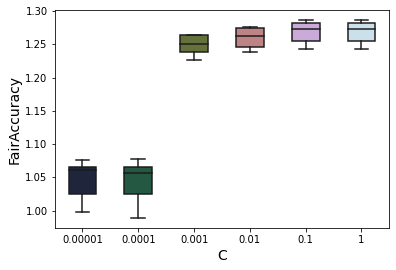

In [24]:
# Plot boxplot for Accuracy
bplot = sb.boxplot( 
                 data=fairdiff_new, 
                 width=0.5,
                 palette="cubehelix")
# bplot.axes.set_title("Model Comparison, FairAccuracy, Original Adult Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("FairAccuracy", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=accuracy_raw_df_new, 
#               color='black',
#               alpha=0.75)

Testing - Adult

In [19]:
display(Markdown("#### Original Adult dataset"))
print("Final Accuracy Score of Model 5A for Adult Dataset = %f" % adult_clf_diff.accuracy(adult_x_test, adult_y_test))

#### Original Adult dataset

Final Accuracy Score of Model 5A for Adult Dataset = 0.803521


## 3.1.1 German Dataset

In [31]:
# Instantiate Classifier
german_clf_diff = LogisticClassifier(train_german, unprivileged_groups, privileged_groups)
# train classifier
german_clf_diff.train(german_x_train, german_y_train,None)

Train German

In [32]:
# For original german dataset
# Compute fairdiff and accuracy over folds and over Cs
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
fairdiff = []
fairdiff_scores = []

for value in C:
  clf = LogisticClassifier(train_german, unprivileged_groups, privileged_groups, C=value, solver="liblinear", penalty="l2")
  clf.train(german_x_train, german_y_train,None)
  mean, scores = clf.accuracy_fairness_score(german_x_train, german_y_train)                                                               
  fairdiff.append(mean)
  fairdiff_scores.append(scores)

In [33]:
fairdiff_new = scores_to_df(fairdiff_scores)

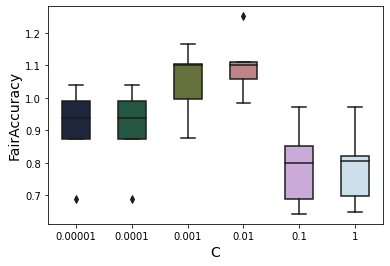

In [35]:
# Plot boxplot for Accuracy
bplot = sb.boxplot( 
                 data=fairdiff_new, 
                 width=0.5,
                 palette="cubehelix")
# bplot.axes.set_title("Model Comparison, FairAccuracy, Original German Dataset", fontsize=16)
bplot.set_xlabel("C", fontsize=14)
bplot.set_ylabel("FairAccuracy", fontsize=14)
bplot.tick_params(labelsize=10)

# # add swarmplot
# bplot=sb.swarmplot(data=accuracy_raw_df_new, 
#               color='black',
#               alpha=0.75)

Testing - German

In [39]:
display(Markdown("#### Original german dataset"))
print("Final Accuracy Score of Model 5G for german Dataset = %f" % german_clf_diff.accuracy(german_x_test, german_y_test))

#### Original german dataset

Final Accuracy Score of Model 5G for german Dataset = 0.730000


## 3.2 Learning Fair Representations from Datasets 

Optimise for both Accuracy and Fairness by using learned fair representations.

This notebook demonstrates the use of LFR pre-processing algorithm for encoding data but hiding information related to protected attributes.

In [51]:
# Mitigate the bias via learned fair representations.
# Use the fit method like a classifier, use the generated instance weights in the training phase in subsequent step.
# switch back working directory for german dataset 
# do german first because it is active dataset

# Dataset 1 - german
# also redefine privileged and unprivileged groupings -
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

TR = LFR(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
TR = TR.fit(train_german)

# german_lfr_trn = TR.transform(train_german, thresh = 0.5)
german_lfr_trn = TR.transform(train_german)
german_lfr_trn = train_german.align_datasets(german_lfr_trn)

# german_lfr_tst = TR.transform(test_german, thresh = 0.5)
german_lfr_tst = TR.transform(test_german)
german_lfr_tst = train_german.align_datasets(german_lfr_tst)



Mean difference:  0.00
Disparate impact: 1.00


In [53]:
# Instantiate a Classifier
german_clf_lfr = LogisticClassifier(german_lfr_trn, unprivileged_groups, privileged_groups)
# train classifier
german_clf_lfr.train(german_x_train, german_y_train, german_lfr_trn.instance_weights)

In [56]:
# For reweighed adult dataset
# Compute fairness and accuracy over folds and over Cs
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
fairness = []
accuracy = []
accuracy_raw = []
fairness_raw = []
for value in C:
  clf = LogisticClassifier(german_lfr_trn, unprivileged_groups, privileged_groups, C=value, solver="liblinear", penalty="l2")
  clf.train(german_x_train, german_y_train, fit_params=german_lfr_trn.instance_weights)
  fairness.append(clf.fairness_model_selection(german_x_train, german_y_train))
  accuracy.append(clf.accuracy(german_x_train, german_y_train))
  accuracy_raw.append(clf.accuracy_raw(german_x_train, german_y_train))
  fairness_raw.append(clf.fairness_raw(german_x_train, german_y_train))

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

In [ ]:
display(Markdown("#### Reweighed Adult training dataset Metrics"))

# Best Accuracy score, Fairness score and corresponding Cs
adult_accuracy_comparison = dict(zip(C, accuracy))
best_C_acc = max(adult_accuracy_comparison, key=lambda key: adult_accuracy_comparison[key])
adult_fairness_comparison = dict(zip(C, fairness))
best_C_fair = max(adult_fairness_comparison, key=lambda key: adult_fairness_comparison[key])
print("Best C value for accuracy: ", best_C_acc, "with score:", adult_accuracy_comparison[best_C_acc])
print("Best C value for fairness: ", best_C_fair, "with score:", adult_fairness_comparison[best_C_fair])

#### Reweighed Adult training dataset Metrics

Best C value for accuracy:  0.1 with score: 0.8032701262503206
Best C value for fairness:  0.01 with score: -0.012607869286405981


## 2.2 Adult Dataset (Rerepresented) - Model Selection